In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from intercluster.plotting import *
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.mining import *
from intercluster.pruning import *
from intercluster.experiments import *

%load_ext autoreload
%autoreload 2

In [20]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 32
})

palette = sns.color_palette("husl", 8)
#cmap = ListedColormap(palette)

cmap = ListedColormap(sns.color_palette("tab20", 20))

color_dict = {
    'KMeans' : 'grey',
    'DBSCAN' : 'grey',
    'Decision-Tree': cmap(0),
    'Removal-Tree': cmap(2),
    'Exp-Tree': cmap(4),
    'ExKMC': cmap(6),
    'Shallow-Tree': cmap(8),
    'CBA': cmap(10),
    'IDS': cmap(12),
    'DSCluster-Association-Rules': cmap(16),
    'DSCluster-Pointwise-Rules': cmap(18)
}

linestyle_dict = {
    'KMeans' : 'dashed',
    'DBSCAN' : 'dashed',
    'Decision-Tree' : 'solid',
    'Removal-Tree' : 'dashed',
    'Exp-Tree' : 'dashed',
    'ExKMC' : 'solid',
    'Shallow-Tree': 'dashed',
    'CBA': 'dashed',
    'IDS': 'dashed',
    'DSCluster-Association-Rules': 'solid',
    'DSCluster-Pointwise-Rules': 'solid'
}

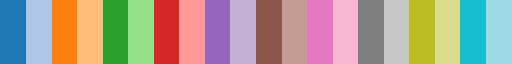

In [12]:
cmap

# Experiment Plotting:
The following is what we use to gather computed information and produce plots/tables. Note that 
our distribution plots are more reliant upon having the data readily available, and 
are therefore plotted as a part of the `interpretable_measurements.py` and `explanation_tree.py`
files. 

In [42]:
# Specify a dataset
dataset = 'climate'

# Specify an experiment
experiment = 'max_rules'

# Specify reference clustering
ref = 'kmeans'

### Max Rules / Lambdas Experiments

In [43]:
# Load experiment results
fname = "../data/experiments/" + dataset + "/" + experiment + "/exp_" + ref + ".csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2], index_col=0)

# Computes statistics:
grouped = experiment_df.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

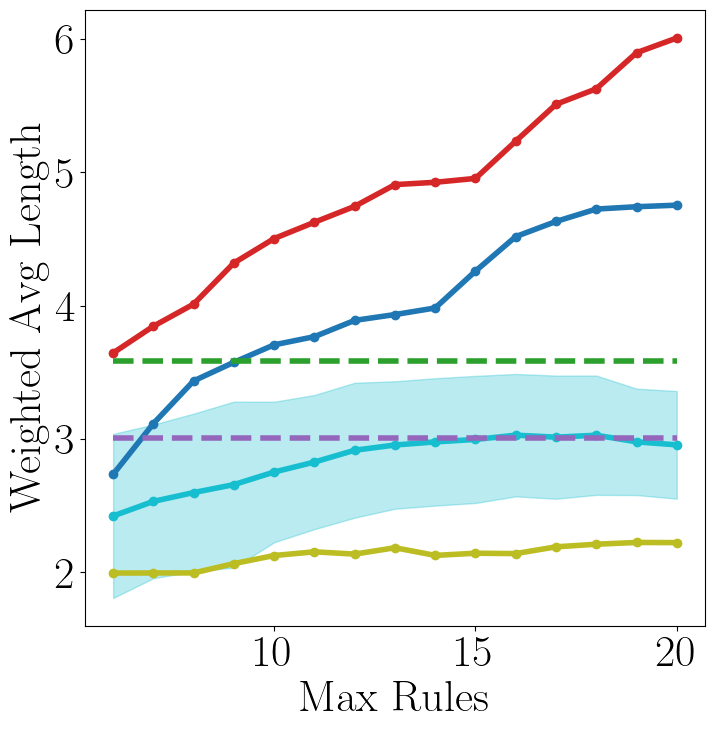

In [51]:
#measurement = 'Coverage-Mistake-Score'
#measurement = 'Silhouette-Score'
measurement = 'Weighted-Avg-Length'
xaxis = True
yaxis = True

measurement_mean_df = mean_df[measurement]
measurement_std_df = std_df[measurement]

# Plot results
fig,ax = plt.subplots(1,1,figsize=(8,8))

for method in measurement_mean_df.columns:
    if measurement_mean_df[method].isnull().all():
        continue
    elif measurement_mean_df[method].nunique() == 1:
        ax.hlines(
            y = measurement_mean_df[method].iloc[0],
            xmin = measurement_mean_df.index.min(),
            xmax = measurement_mean_df.index.max(),
            color = color_dict[method],
            alpha = 1,
            label = method,
            linewidth = 4,
            linestyle = linestyle_dict[method]
        )
    else:
        ax.plot(
            measurement_mean_df.index,
            measurement_mean_df[method], 
            color = color_dict[method],
            label = method,
            linewidth = 4,
            marker='o',
            markersize = 6,
            alpha = 1
        )
        ax.fill_between(
            measurement_mean_df.index, 
            measurement_mean_df[method] - measurement_std_df[method],
            measurement_mean_df[method] + measurement_std_df[method],
            color= color_dict[method],
            alpha=0.3
        )


if not xaxis:
    plt.xticks([])
if not yaxis:
    plt.yticks([])

plt.xlabel('Max Rules')
plt.ylabel(measurement.replace("-", " "))

plt.savefig(
    "../figures/" + dataset + "/" + experiment + "/" + ref + "/" + measurement.replace(" ", "_") + ".png",
    bbox_inches='tight'
)
plt.show()
    

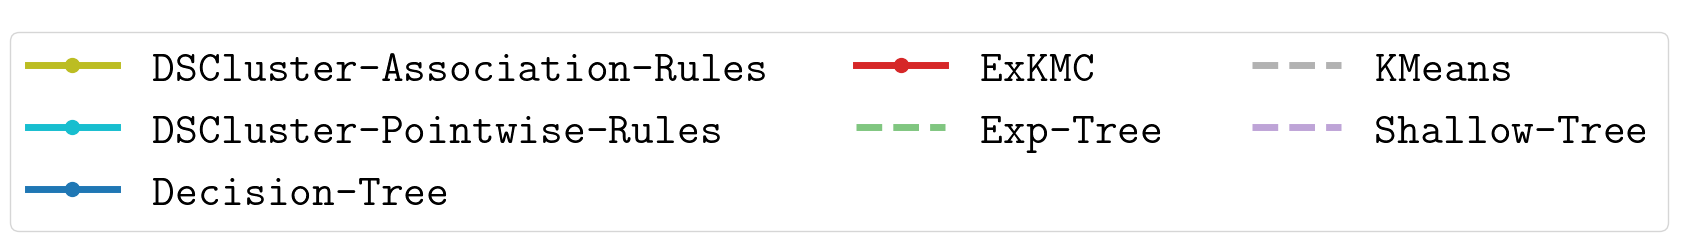

In [49]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))

legend_elements = []
for method in measurement_mean_df.columns:
    if measurement_mean_df[method].nunique() == 1:
        legend_elements += [
            mlines.Line2D(
                [], [],
                color=color_dict[method],
                lw=5,
                linestyle = linestyle_dict[method],
                label=rf"\texttt{{{method}}}",
                alpha=0.6
            )
        ]
    else:
        legend_elements += [
            mlines.Line2D(
                [], [],
                marker = 'o',
                markersize=10,
                color=color_dict[method],
                lw=5,
                label=rf"\texttt{{{method}}}",
                alpha=1
            )
        ]

ax.legend(handles=legend_elements, ncol=3)
ax.axis('off')

plt.savefig(
    "../figures/" + dataset + "/" + experiment + "/" + ref + "/legend.png",
    bbox_inches='tight'
)

### Robustness

In [34]:
# Load experiment results
fname = "../data/experiments/" + dataset + "/robustness/exp_" + ref + ".csv"
experiment_df = pd.read_csv(fname, header=[1], index_col=0)

# Computes statistics:
#grouped = experiment_df.T.groupby(level = [0,1])
mean_df = experiment_df.mean().T
std_df = experiment_df.std().T

In [35]:
mean_df

Decision-Tree                  0.007490
Exp-Tree                       0.009148
CBA                            0.020308
IDS                            0.020308
DSCluster-Association-Rules    0.006911
DSCluster-Pointwise-Rules      0.005540
dtype: float64

In [36]:
std_df

Decision-Tree                  0.001923
Exp-Tree                       0.002099
CBA                            0.002384
IDS                            0.002384
DSCluster-Association-Rules    0.002120
DSCluster-Pointwise-Rules      0.001541
dtype: float64

In [145]:
seed = 1234
np.random.seed(seed)

In [147]:
####################################################################################################
# Read and process data:
#data, data_labels, feature_labels, scaler = load_preprocessed_digits()
#data_labels = labels_format(data_labels)
#data = data
#data_labels = data_labels
#n,d = data.shape
#n_unique_labels = len(unique_labels(data_labels))

data, data_labels, feature_labels, scaler = load_preprocessed_climate('../data/climate')
n,d = data.shape
n_clusters = 6

# Parameters:
lambda_val = 5.0
n_rules = 6

# KMeans:
kmeans_n_clusters = n_clusters

# DBSCAN
n_core = 20
epsilon = 1.5

# Shallow Tree
depth_factor = 0.03

# Association Rule Mining:
association_n_mine = 10000
association_rule_miner = AssociationRuleMiner(max_rules = association_n_mine, bin_type = 'mdlp')

# Pointwise Rule Mining:
pointwise_samples_per_point = 10
pointwise_prob_dim = 1/2
pointwise_prob_stop = 8/10
pointwise_rule_miner = PointwiseMinerV2(
    samples = pointwise_samples_per_point,
    prob_dim = pointwise_prob_dim,
    prob_stop = pointwise_prob_stop,
)

# IDS:
ids_lambdas = [
    1/association_n_mine,
    1/(2 * data.shape[1] * association_n_mine),
    1/(len(data) * (association_n_mine**2)),
    1/(len(data) * (association_n_mine**2)),
    0,
    1/(data.shape[0] * association_n_mine),
    1/(data.shape[0])
]


####################################################################################################
# Run initial clusterings:

# DBSCAN
#dbscan = DBSCAN(eps=epsilon, min_samples=n_core)
#dbscan.fit(data)
#dbscan_labels_ = dbscan.labels_
#dbscan_labels = labels_format(dbscan_labels_)
#dbscan_n_clusters = len(unique_labels(dbscan_labels, ignore = {-1}))
#dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = dbscan_n_clusters, ignore = {-1})


# KMeans
k = kmeans_n_clusters
kmeans = KMeans(n_clusters = kmeans_n_clusters, random_state=seed)
kmeans.fit(data)
kmeans_labels_ = kmeans.labels_
kmeans_labels = labels_format(kmeans_labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = kmeans_n_clusters)


# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, kmeans_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = kmeans_n_clusters, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = len(np.unique(kmeans_labels_)))
rem_tree.fit(data, kmeans_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = kmeans_n_clusters, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# ExKMC
exkmc = ExkmcTree(k = kmeans_n_clusters, kmeans = kmeans, max_leaf_nodes = n_rules)
exkmc.fit(data, kmeans_labels)
exkmc_labels = exkmc.predict(data)
exkmc_labels_ = flatten_labels(exkmc_labels)
exkmc_leaf_labels = exkmc.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
exkmc_rule_assignment = labels_to_assignment(exkmc_leaf_labels, n_labels = kmeans_n_clusters, ignore = {-1})
exkmc_data_to_rule_assignment = exkmc.get_data_to_rules_assignment(data)
exkmc_data_to_cluster_assignment = exkmc_data_to_rule_assignment @ exkmc_rule_assignment


# Shallow Tree
shallow_tree = ShallowTree(n_clusters = kmeans_n_clusters, depth_factor = depth_factor, kmeans_random_state=seed)
shallow_tree.fit(data, kmeans_labels)
shallow_tree_labels = shallow_tree.predict(data)
shallow_tree_labels_ = flatten_labels(shallow_tree_labels)
shallow_tree_leaf_labels = shallow_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
shallow_tree_rule_assignment = labels_to_assignment(shallow_tree_leaf_labels, n_labels = kmeans_n_clusters, ignore = {-1})
shallow_tree_data_to_rule_assignment = shallow_tree.get_data_to_rules_assignment(data)
shallow_tree_data_to_cluster_assignment = shallow_tree_data_to_rule_assignment @ shallow_tree_rule_assignment


# Decision Set Clustering — Association Rules
association_rule_miner = AssociationRuleMiner(max_rules = association_n_mine, bin_type = 'mdlp')
dsclust1 = DSCluster(lambd = lambda_val, n_rules = n_rules, rule_miner = association_rule_miner)
dsclust1.fit(data, kmeans_labels)
dsclust1_labels = dsclust1.predict(data)
dsclust1_labels_ = flatten_labels(dsclust1_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust1_rule_assignment = labels_to_assignment(dsclust1.decision_set_labels, n_labels = kmeans_n_clusters, ignore = {-1})
dsclust1_data_to_rule_assignment = dsclust1.get_data_to_rules_assignment(data)
dsclust1_data_to_cluster_assignment = dsclust1_data_to_rule_assignment @ dsclust1_rule_assignment 


# Decision Set Clustering — Pointwise
pointwise_rule_miner = PointwiseMinerV2(
    samples = pointwise_samples_per_point,
    prob_dim = pointwise_prob_dim,
    prob_stop = pointwise_prob_stop,
)
dsclust2 = DSCluster(lambd = lambda_val, n_rules = n_rules, rule_miner = pointwise_rule_miner)
dsclust2.fit(data, kmeans_labels)
dsclust2_labels = dsclust2.predict(data)
dsclust2_labels_ = flatten_labels(dsclust2_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust2_rule_assignment = labels_to_assignment(dsclust2.decision_set_labels, n_labels = kmeans_n_clusters, ignore = {-1})
dsclust2_data_to_rule_assignment = dsclust2.get_data_to_rules_assignment(data)
dsclust2_data_to_cluster_assignment = dsclust2_data_to_rule_assignment @ dsclust2_rule_assignment 


/Users/quinn/research/intercluster/repo/.venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [152]:
# Robustness Experiment: Fraction of data points which change cluster assignment 
# after trials with random noise
samples = 10000

dtree_counts = np.zeros(samples)
remtree_counts = np.zeros(samples)
exkmc_counts = np.zeros(samples)
shallowtree_counts = np.zeros(samples)
dsclust1_counts = np.zeros(samples)
dsclust2_counts = np.zeros(samples)

for i in range(samples):
    # Generate random noise
    noise = np.random.normal(0, 0.1, size = data.shape)
    noisy_data = data + noise

    # Decision Tree
    dtree_noisy_labels = dtree.predict(noisy_data)
    dtree_counts[i] = label_differences(
        true_labels = dtree_labels,
        pred_labels = dtree_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # Removal Tree
    rem_tree_noisy_labels = rem_tree.predict(noisy_data, remove_outliers = False)
    remtree_counts[i] = label_differences(
        true_labels = rem_tree_labels,
        pred_labels = rem_tree_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # ExKMC
    exkmc_noisy_labels = exkmc.predict(noisy_data)
    exkmc_counts[i] = label_differences(
        true_labels = exkmc_labels,
        pred_labels = exkmc_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # Shallow Tree
    shallow_tree_noisy_labels = shallow_tree.predict(noisy_data)
    shallowtree_counts[i] = label_differences(
        true_labels = shallow_tree_labels,
        pred_labels = shallow_tree_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # DSCluster - Association Rules
    dsclust1_noisy_labels = dsclust1.predict(noisy_data)
    dsclust1_counts[i] = label_differences(
        true_labels = dsclust1_labels,
        pred_labels = dsclust1_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

    # DSCluster - Pointwise
    dsclust2_noisy_labels = dsclust2.predict(noisy_data)
    dsclust2_counts[i] = label_differences(
        true_labels = dsclust2_labels,
        pred_labels = dsclust2_noisy_labels,
        percentage = True,
        ignore = {-1}
    )

In [ ]:
color_dict = {
    'KMeans' : 'grey',
    'DBSCAN' : 'grey',
    'Decision-Tree': cmap(5),
    'Removal-Tree': cmap(1),
    'ExKMC': cmap(0),
    'Shallow-Tree': cmap(3),
    'IDS': cmap(2),
    'DSCluster-Association-Rules': cmap(6),
    'DSCluster-Pointwise-Rules': cmap(7)
}

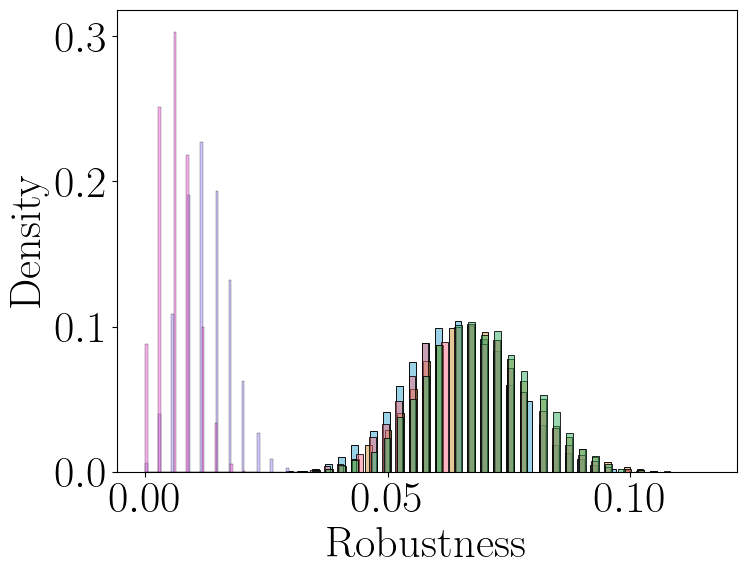

In [153]:
# Plot histogram of robustness results
fig,ax = plt.subplots(figsize = (8,6))
sns.histplot(dtree_counts, alpha = 0.5, stat = 'probability', label = 'Decision-Tree', color = color_dict['Decision-Tree'], ax = ax)
sns.histplot(remtree_counts, alpha = 0.5, stat = 'probability', label = 'Removal-Tree', color = color_dict['Removal-Tree'], ax = ax)
sns.histplot(exkmc_counts, alpha = 0.5, stat = 'probability', label = 'ExKMC', color = color_dict['ExKMC'], ax = ax)
sns.histplot(shallowtree_counts, alpha = 0.5, stat = 'probability', label = 'Shallow-Tree', color = color_dict['Shallow-Tree'], ax = ax)
sns.histplot(dsclust1_counts, alpha = 0.5, stat = 'probability', label = 'DSCluster-Association-Rules', color = color_dict['DSCluster-Association-Rules'], ax = ax)
sns.histplot(dsclust2_counts, alpha = 0.5, stat = 'probability', label = 'DSCluster-Pointwise-Rules', color = color_dict['DSCluster-Pointwise-Rules'], ax = ax)
ax.set_xlabel('Robustness')
ax.set_ylabel('Density')
#ax.legend()
plt.savefig(
    "../figures/" + dataset + "/robustness/robustness_no_outliers.png",
    bbox_inches='tight'
)
plt.show()

### Older experiments

In [16]:
# Colors and Modules for plotting:
colormap = distortion_cmap
baseline_list = ['KMeans-Full', 'IMM-Full']

# This is just a list of column names to look up in the dataframe
module_list = ['IMM', 'IMM-outliers', 'Forest-Depth-2', 
               'Forest-Depth-3','Forest-Depth-4']

# And these are their corresponding latex versions
legend_module_list = [r'\texttt{IMM}', r'\texttt{IMM-outliers}', r'\texttt{Forest-Depth-2}', 
               r'\texttt{Forest-Depth-3}',r'\texttt{Forest-Depth-4}']

# We give colors to each as follows
color_dict = {mod : i for i,mod in enumerate(module_list)}

In [17]:
# Specify the model:
model = 'Forest-Depth-2'

# And then we'll compute ratios for clustering costs:
measure = 'normalized-clustering-cost'
xlabel = 'minimum coverage'
ylabel = 'distortion'

# Uncomment here to save:
#fname = '../figures/relative_coverage/' + ylabel + '/' + dataset + '/' + model + '.png'
fname = None

xaxis = False
if dataset == 'fashion':
    xaxis = True

yaxis = False
if model == 'IMM-outliers':
    yaxis = True

if not xaxis:
    xlabel = ''
if not yaxis:
    ylabel = ''

# Compute distortion with cost ratios:
cost_df = experiment_df[measure][model]

# Divide by the reference:
distortion_df = cost_df[[model, 'IMM', 'KMeans']].div(cost_df['KMeans'], level=1)

# Find the mean and standard deviation
plot_df = distortion_df.groupby(level=0, axis=1).mean()
plot_std_df = distortion_df.groupby(level=0, axis=1).std()

# More plotting info:
plot_colors = [colormap(color_dict[mod]) for mod in plot_df.columns if mod != 'KMeans']
plot_cmap = ListedColormap(plot_colors)
domain_array = np.array([list(np.linspace(0.5,1,11))] * len(plot_df.columns)).T
domain_df = pd.DataFrame(domain_array, columns = plot_df.columns)

xlim = (0.49, 1.01)
#ylim = (plot_df.min().min() - 0.05, plot_df.max().max() + 0.05)

if dataset == 'climate':
    ylim = (0.95, 1.1)
elif dataset == 'anuran':
    ylim = (0.95, 1.7)
elif dataset == 'covertype':
    ylim = (0.95, 1.4)
elif dataset == 'digits':
    ylim = (0.95, 1.7)
elif dataset == 'mnist':
    ylim = (0.95, 1.25)
elif dataset == 'fashion':
    ylim = (0.95, 1.4)

experiment_plotter(
    plot_df,
    plot_std_df,
    domain_df,
    xlabel = xlabel,
    ylabel = ylabel,
    cmap = plot_cmap,
    baseline_list = ['KMeans'],
    legend = False,
    xlim = xlim,
    ylim = ylim,
    xaxis = xaxis,
    yaxis = yaxis,
    filename = fname,
)

KeyError: 'normalized-clustering-cost'

(0.0, 1.0, 0.0, 1.0)

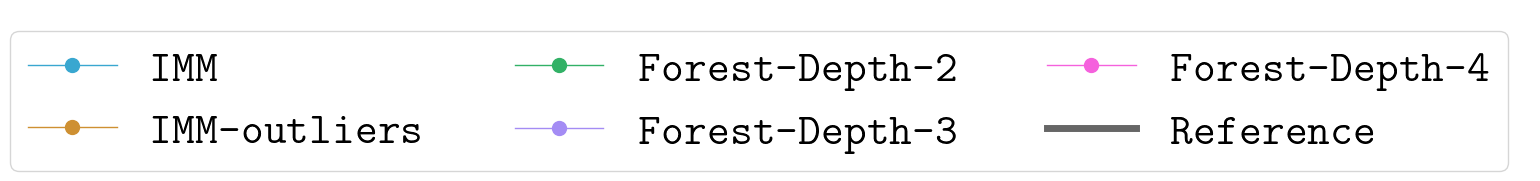

In [ ]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(legend_module_list)
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=5,
        linestyle = '-',
        label=r"\texttt{Reference}",
        alpha=0.6
    )
]

ax.legend(handles=legend_elements, ncol=3)
ax.axis('off')
#plt.savefig('../figures/relative_coverage/distortion_legend.png', bbox_inches = 'tight', dpi = 300)

### Interpretable Measurements:

In [27]:
# Interpretable Measurements Table
fname = "../data/experiments/" + dataset + "/measurements.csv"
inter_measures_df = pd.read_csv(fname, index_col=0)
inter_measures_df

,coverage,max-rule-length,normalized-clustering-cost,overlap,weighted-average-rule-length
Row,,,,,
forest_depth_2,0.819086,2.0,35.508812,1.160737,2.000000
forest_depth_3,0.809543,3.0,33.223462,1.113150,3.000000
forest_depth_4,0.835143,4.0,32.328097,1.075334,3.627513
forest_depth_imm,0.823486,7.0,32.266952,1.083755,3.802600
imm,1.000000,7.0,39.302320,1.000000,5.052857
outlier,0.800057,6.0,36.508056,1.000000,4.946861


In [28]:
# Additional Results for explanation tree
fname = "../data/experiments/" + dataset + "/explanation_tree.csv"
explanation_tree_df = pd.read_csv(fname, index_col=0)
explanation_tree_df

,normalized-clustering-cost,overlap,coverage,max-rule-legnth,weighted-average-rule-length
0,29.855588,1.0,0.715771,7,5.109452
